In [1]:
import pandas as pd
import polars as pl
from polars import col as pc
import plotly.express as px

In [2]:
df = pl.read_csv('land_value.csv', infer_schema_length=1000000)

In [3]:
len(df)

6845549

In [4]:
df2 = df.filter(pc.area.is_not_null() & (pc.area_type == 'Square Meters'))

In [5]:
df2.head()

district_code,district_name,property_id,file_datetime,property_name,property_unit_number,property_house_number,property_street_name,property_locality,property_post_code,area,area_type,contract_date,settlement_date,purchase_price,zone_code,zone_name,nature_property,primary_purpose,strata_number,component_code,sale_code,interest_sale,dealing_number,property_description,purchaser_vendor,dimensions,filetype
i64,str,i64,str,str,str,str,str,str,i64,f64,str,i64,i64,i64,str,str,str,str,i64,str,str,i64,str,str,str,str,str
234,"""BROKEN HILL""",2613690,"""20130325 01:38…",null,null,"""714""","""BERYL ST""","""BROKEN HILL""",2880,1328.0,"""Square Meters""",20121128,20130205,280000,"""A""","""Residential""","""Residence""","""RESIDENCE""",null,"""CC""",null,0,"""AH554050""","""3301, 3909/757…","""Purchaser, Pur…",null,"""sales"""
234,"""BROKEN HILL""",2613771,"""20130325 01:38…",null,null,"""102""","""BERYL ST""","""BROKEN HILL""",2880,505.9,"""Square Meters""",20130207,20130307,77500,"""A""","""Residential""","""Residence""","""RESIDENCE""",null,"""CD""",null,0,"""AH615023""","""B/341084""","""Purchaser, Ven…",null,"""sales"""
234,"""BROKEN HILL""",2619331,"""20130325 01:38…",null,null,"""18 A""","""MORGAN ST""","""BROKEN HILL""",2880,1024.0,"""Square Meters""",20130125,20130301,130000,"""A""","""Residential""","""Residence""","""RESIDENCE""",null,"""AM""",null,0,"""AH610946""","""5273/757298""","""Purchaser, Pur…",null,"""sales"""
234,"""BROKEN HILL""",2620431,"""20130325 01:38…",null,null,"""223""","""PELL ST""","""BROKEN HILL""",2880,505.9,"""Square Meters""",20130207,20130307,87500,"""A""","""Residential""","""Residence""","""RESIDENCE""",null,"""AL""",null,0,"""AH615022""","""B/974501""","""Purchaser, Ven…",null,"""sales"""
234,"""BROKEN HILL""",2615579,"""20130325 01:38…",null,null,"""418""","""COBALT ST""","""BROKEN HILL""",2880,499.5,"""Square Meters""",20130206,20130308,92000,"""A""","""Residential""","""Residence""","""RESIDENCE""",null,"""CD""",null,0,"""AH615737""","""A/331398 A/350…","""Purchaser, Pur…",null,"""sales"""


In [35]:
df3 = df2.with_columns(
    ts = pc.settlement_date.cast(str).str.strptime(pl.Datetime, '%Y%m%d')
).filter(
    pc.zone_name.str.to_lowercase().str.contains('residential')
).group_by(
    pc.ts.dt.round('1mo'),
    pc.district_name,
).agg(
    price_per_m2=(pc.purchase_price / pc.area).median(),
).filter(
    pl.len().over(pc.district_name) > 100,
    pc.price_per_m2 < 100_000,
    pc.price_per_m2 > 10,
    pc.ts > pd.Timestamp('2014-01-01'),
    pc.ts < pd.Timestamp.now(),
    pc.district_name.is_not_null(),
).with_columns(
    multiplier = pc.price_per_m2.quantile(0.9).over('district_name') / pc.price_per_m2.quantile(0.1).over('district_name')
)

In [36]:
df3.head(), len(df3)

(shape: (5, 4)
 ┌─────────────────────┬──────────────────┬──────────────┬────────────┐
 │ ts                  ┆ district_name    ┆ price_per_m2 ┆ multiplier │
 │ ---                 ┆ ---              ┆ ---          ┆ ---        │
 │ datetime[μs]        ┆ str              ┆ f64          ┆ f64        │
 ╞═════════════════════╪══════════════════╪══════════════╪════════════╡
 │ 2017-02-01 00:00:00 ┆ WOLLONDILLY      ┆ 574.876686   ┆ 2.477665   │
 │ 2020-10-01 00:00:00 ┆ LIVERPOOL PLAINS ┆ 302.530253   ┆ 2.706635   │
 │ 2023-07-01 00:00:00 ┆ NEWCASTLE        ┆ 1726.058417  ┆ 2.081732   │
 │ 2021-03-01 00:00:00 ┆ CITY OF SYDNEY   ┆ 15906.471558 ┆ 1.622023   │
 │ 2021-06-01 00:00:00 ┆ CITY OF SYDNEY   ┆ 15313.881521 ┆ 1.622023   │
 └─────────────────────┴──────────────────┴──────────────┴────────────┘,
 11325)

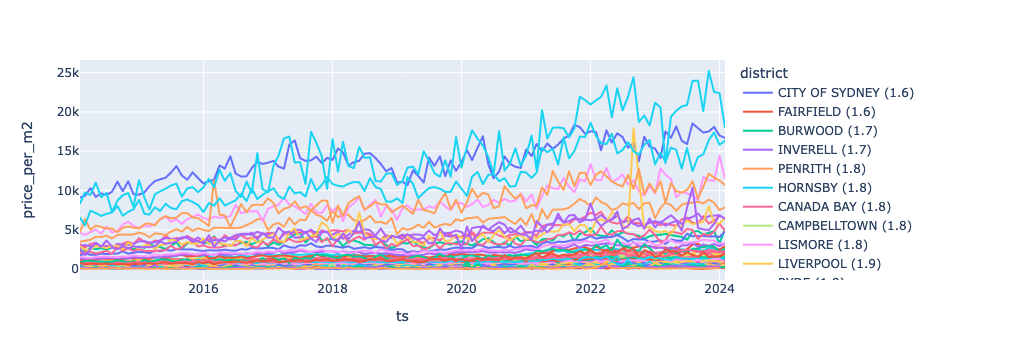

In [39]:
x = df3.to_pandas().sort_values(['multiplier', 'district_name', 'ts'])
x['district'] = x.district_name + ' (' + x.multiplier.round(1).astype(str) + ')'
px.line(
    x,
    x='ts', y='price_per_m2', color="district",
    # log_y=True,
)